# Project 1: Pose Graph Optimization (scratch + g2o)
TEAM-ID: 11        
TEAM-NAME: little-boy        
YOUR-ID: 2018111027    
YOUR-NAME: Mohammad Nomaan Qureshi     

### Submission
Zip a folder of the following:
1. Files that you were provided with: `Project-1.ipynb`, the folders `misc` and `dataset`. Rest of the files asked in the questions below must be generated when i run the code. If generation of any file is computationally intensive, add `filename_backup.extension` where `filename.extension` is the expected name of file when i run the code. (For example, next point.)
2. Add `opt_backup.g2o` (described below) in outermost directory. Here, `opt.g2o` is the expected name of the file when I run the code.
3. For images of any results (like plots), save it in `./misc` folder.

On Moodle, all you have to submit is the jupyter notebook. But make sure to call the necessary functions explicitly (as specified in the notebook). The name of the zipped file being submitted to Moodle Assignment portal MUST BE `ID_Teamname_Firstname`. More details [here](https://www.notion.so/saishubodh/Course-Information-4c9e487b118547b2ba91d24e0dcaf04e#f2707a04f2a0446bac77763b47ba4bac).

On GitHub classrooms, the latest commit before the deadline will be considered as the submission. 

The deadline is Oct 16, 23:55 IST. Please get started ASAP, there is no way you can finish this project during the last few days before the deadline.

### General instructions

This ipython notebook (`.ipynb`) on GitHub is self-sufficient and has all the information you need to get started with the assignment, you don't need any corresponding PDF doc. Just fire up the notebook and get going!

General information like installation instructions in supplementary notebook "Project-1_Code-Walkthrough". Please take a look at it before you start this assignment.

Whenever I mention some `func()` below, I am referring to the "helper functions" in another supplementary notebook "Project-1_Code-Walkthrough" provided to you. Whenever I ask you to insert image below, it is better to save the image in `misc` and load it using `![file_name](file_location)` instead of directly pasting.    

[[CP-]] refers to CheckPoint, you have to ensure you do the tasks at each of the [[CP-]] places below. Not ensuring [[CP-B]] (CheckPoint-Basic) will incur heavy penalty and potentially 0 for that sub-section, and [[CP-M]] (CheckPoint-Marks) has a particular mark weightage depending on your results at that particular CP. You have to add these answers to the tasks after your code in a section already titled `Section_number Answer` for example, `2.1 Answer`.

If you face any issues related to coding/installation, please raise an [issue here](https://github.com/Shubodh/MR-project1-pgo/issues). For any conceptual doubts, you can ask on Moodle or Teams as usual.

# 0. Introduction

In this project, we are going to use a non-linear weighted least squares optimization approach to solve the problem of getting a better estimate of our robot's trajectory. Least squares formulations are widely used for optimization, be it computer vision or robotics or machine learning. We will dive deep into it during this project and you will have complete clarity on optimization for vector-valued residual functions. 

In this "Introduction" section, I am going to provide an introduction for SLAM problem for a robot operating in the 2D world. It is 2. section in this Project. The 1D SLAM problem (1.) is far much simpler to understand and will be described directly in the 1. section. 

In a 2D world, a robot has 3 degrees of freedom, i.e. its pose in the world can be expressed by the state vector $\mathbf{x}=(x, y, \theta)^{\mathrm{T}}$. For the scope of this project, we are interested only in the robot's trajectory through the $2 \mathrm{D}$ world, and NOT in distinct landmarks or the surronding map of the environment, i.e. we are only interested in "L"ocalization part of SLAM. 

Therefore, we can represent it as a graph where the vertices represent robot poses $\mathbf{x}_{i}$ and edges represent the spatial constraints between these poses. Such a map is generally called a pose graph.

Two different kinds of constraints are necessary for pose graph SLAM. The first are
odometric constraints that connect two successive states $\mathbf{x}_{i}$ and $\mathbf{x}_{i+1}$ via a motion model. Furthermore, in order to perform loop closing, the robot has to recognize places it already visited before. This place recognition is also a part of the front-end and provides the second type of constraint, the loop closure constraints. These constraints connect two not necessarily successive poses $\mathbf{x}_{i}$ and $\mathbf{x}_{j}$.


![SLAM-trajectory-lc.png](misc/SLAM-trajectory-lc.png)   ![SLAM-trajectory-robust.png](misc/SLAM-trajectory-robust.png) (Source: [Sunderhauf 2012](https://core.ac.uk/download/pdf/89299995.pdf))

You will start from the inaccurate pose graph with odometry and loop closure information and by the end of this Project, you end up with an optimized pose graph (see above images) which should look close to ground truth trajectory. You can watch [this video](https://youtu.be/saVZtgPyyJQ) to get an intuition for what we're about to do.

Okay, that's enough of theory. Let's get out hands dirty with the code!

In [2]:
import matplotlib.pyplot as plt
import math
import os
import jax.numpy as jnp #see supplementary notebook to see how to use this
from jax import jacfwd
import jax
# If you're `importing numpy as np` for debugging purposes, 
# while submitting, please remove 'import numpy' and replace all np's with jnp's.(more in supplementary notebook)

# 1. Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. It has been made [available here](https://www.notion.so/saishubodh/Solved-Example-1D-SLAM-weighted-LS-Illustrating-Sparsity-in-SLAM-d8b45893843b4377b07b1d4aa1aab4de). Your first task is to code this from scratch. [[CP-M]]

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct `jax`'s `jacobian`. Its usage is explained in the supplementary notebook.

In [3]:
##############################################################################
# TODO: Code for Section 1                                                   #
#pass
import jax.numpy as jnp

def f(x,u):
    return x+u

u = jnp.array([1.1,1.0,1.1,-2.7,0])
x = jnp.array([0,1.1,2.1,3.2,0.5])

def getfx(x, u):
    a = jnp.append(f(x,u)[:-1],jnp.array([f(x[0],u[-1]),x[0]]))
    b = jnp.append(x[1:],jnp.array([x[-1],0]))
    return a-b

def gn(x,u,max_iterations,tol):

    costs_list=[]
    Xs_list=[]
    itr = 0
    
    while itr < max_iterations:
        fx = getfx(x, u)

        w = jnp.array([
            [100,0,0,0,0,0],
            [0,100,0,0,0,0],
            [0,0,100,0,0,0],
            [0,0,0,100,0,0],
            [0,0,0,0,100,0],
            [0,0,0,0,0,1000],
        ])

        j=jnp.array([
            [1,-1,0,0,0],
            [0,1,-1,0,0],
            [0,0,1,-1,0],
            [0,0,0,1,-1],
            [1,0,0,0,-1],
            [1,0,0,0,0]
        ])
        
        H = j.T@w@j
        b = j.T@w.T@fx
        x += -jnp.linalg.inv(H)@b

        print("Iteration:",itr+1,"X =",x)

        current_cost = (fx.T@w@fx)/2
        if itr:
            last_cost = costs_list[-1]

        costs_list.append(current_cost)
        Xs_list.append(x)

        if itr and abs(current_cost-last_cost) < tol:
            break
        itr += 1

    return costs_list,Xs_list

cost,x=gn(x,u,10,1e-6)
print('Final Cost =',cost[-1])
print('Final Pose =',x[-1])
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Iteration: 1 X = [-1.6298145e-09  1.0000001e+00  1.9000000e+00  2.8999999e+00
  9.9999934e-02]
Iteration: 2 X = [-3.5762593e-10  1.0000000e+00  1.9000000e+00  2.9000001e+00
  9.9999979e-02]
Iteration: 3 X = [-6.5565198e-10  1.0000000e+00  1.9000000e+00  2.9000001e+00
  9.9999994e-02]
Iteration: 4 X = [-1.1921003e-10  1.0000000e+00  1.9000000e+00  2.9000001e+00
  1.0000000e-01]
Final Cost = 2.5
Final Pose = [-1.1921003e-10  1.0000000e+00  1.9000000e+00  2.9000001e+00
  1.0000000e-01]


# 2. Pose Graph Optimization for 2D SLAM

Things are about to get interesting!

## 2.1 Coding from scratch

### Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

### Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:
1. Initial position
2. Odometry Contraints/Edges: This "edge" information basically tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges
Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://www.notion.so/saishubodh/G2O-Edge-Description-fa07cc28967541dc8a71170de46c5da7) ).

### Details:
1. Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot [[CP-M]] below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](./misc/robot-poses-MR-P1.png)
(Use `draw()` helper function or `g2o_viewer` or `EVO`)

2. Now calculate the residual and the Jacobian and update your parameters using LM.

    1. Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using [[CP-M]] frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster.
    
    2. [[CP-M]] What did you get as the dimension of Jacobian, information matrix and residual? Please add dimensions of Jacobian, Residual, information matrix as part of your descriptive answer 2.1 below (after the code).

3. Regarding LM iterations, stopping criterion, information matrix values.

    1. [[CP-B]] As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notion page link)](https://www.notion.so/saishubodh/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).
    
    2. [[CP-B]] You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

    3. [[CP-M]] You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (next section), you will be getting a close to ground truth trajectory.

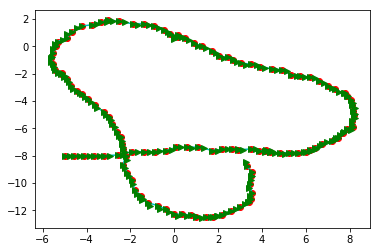

(120,)


In [4]:
##############################################################################
# TODO: Code for Section 2.1                                                 #
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()
    
    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return jnp.array([x_arr, y_arr, theta_arr])

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))

    return (jnp.array( ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta))

def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')

    plt.show()

def makeg2o(x, y, z, g2ofile):
    f = open(g2ofile, "w")
    for i in range(len(x)):
        f.write("VERTEX_SE2"+" " + str(i) + " " + str(x[i]) +" "+ str(y[i]) +" "+ str(z[i])+"\n")
    
    f2 = open("dataset/edges.txt", "r")
    lines = f2.readlines()
    for i in range(1, len(lines)):
        if lines[i][0:3] != "FIX":
            f.write(lines[i])

x, y, theta = readVertex('dataset/gt.txt')
_, _, delx, dely, delt = readEdge('dataset/edges.txt')
edges = readEdge('dataset/edges.txt')
X = []
Y = []
THETA = []
X.append(x[0])
Y.append(y[0])
THETA.append(theta[0])
for i in range(1, x.shape[0]):
    X.append(X[i-1] + delx[i-1]* jnp.cos(THETA[i-1]) - dely[i-1]*jnp.sin(THETA[i-1]))
    Y.append(Y[i-1] + dely[i-1]* jnp.cos(THETA[i-1]) + delx[i-1]*jnp.sin(THETA[i-1]))
    THETA.append(THETA[i-1] + delt[i-1])

X = jnp.array(X)
Y = jnp.array(Y)
THETA = jnp.array(THETA)
            
vertex = readVertex('./dataset/edges.txt')
edge = readEdge('./dataset/edges.txt')
    
draw(X,Y,THETA)
print(X.shape)
makeg2o(X,Y,THETA,g2ofile="edges-poses_backup.g2o")
makeg2o(X,Y,THETA,g2ofile="edges-poses.g2o")

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

In [5]:
def getx(x,thetha,delx,dely):
    x=x.reshape((-1, 1))
    thetha = thetha.reshape((-1, 1))
    delx = delx.reshape((-1, 1))
    dely = dely.reshape((-1, 1))
    return x+delx*jnp.cos(thetha)-dely*jnp.sin(thetha) 

def gety(y,thetha,delx,dely):
    y=y.reshape((-1, 1))
    thetha = thetha.reshape((-1, 1))
    delx = delx.reshape((-1, 1))
    dely = dely.reshape((-1, 1))
    return y+dely*jnp.cos(thetha)+delx*jnp.sin(thetha) 

def getth(thetha,delt):
#     dt = dt.reshape((-1,1))
    thetha = thetha.reshape((-1, 1))
    delt = delt.reshape((-1, 1))
    return thetha+delt

In [6]:
# xx -> vertex
def get_fX(vertex,edges):
    x,y,theta=jnp.reshape(vertex,(3,vertex.shape[0]//3))
    x,y, theta = x.reshape((-1,1)), y.reshape((-1,1)), theta.reshape((-1,1))
    x, y, theta= jnp.array(x), jnp.array(y), jnp.array(theta)
    i, j, delx, dely, delthetha, ocl=edges[0], edges[1], edges[2], edges[3], edges[4], len(x)
    #odometry constraint
    odocx, odocy, odocth=getx(x[:-1],theta[:-1],delx[:ocl-1],dely[:ocl-1])-x[1:], gety(y[:-1],theta[:-1],delx[:ocl-1],dely[:ocl-1])-y[1:] , getth(theta[:-1],delthetha[:ocl-1])-theta[1:]
    #loop constrain
    ocl-=1
    iloop, jloop=i[ocl:], j[ocl:]
    loopcx=getx(x[iloop],theta[iloop],delx[ocl:],dely[ocl:])-x[jloop]
    loopcy=gety(y[iloop],theta[iloop],delx[ocl:],dely[ocl:])-y[jloop]
    loocpctx=getth(theta[iloop],delthetha[jloop])-theta[jloop]
    #initial constrains
    initcx, initcy, initth =x[0]-(-5), y[0]-(-8),theta[0]-(0)
    initcx, initcy, initth=initcx.reshape((-1,1)), initcy.reshape((-1,1)), initth.reshape((-1,1))
    final = jnp.concatenate((odocx,odocy,odocth,loopcx,loopcy,loocpctx,initcx,initcy,initth)).reshape(-1)
    return final

In [11]:
def CreateOmega(odo=1, loop=1,init=10):
    omega = jnp.zeros((119*3 + 20*3+3, 119*3 + 20*3+3))
    xodo = odo
    yodo = odo
    todo = odo
    xloop = loop
    yloop = loop
    tloop = loop
    
    for i in range(119):
        omega = jax.ops.index_update(omega, jax.ops.index[i, i], xodo)
        
    for i in range(119, 2*119):
        omega = jax.ops.index_update(omega, jax.ops.index[i, i], yodo)
    
    for i in range(2*119, 3*119):
        omega = jax.ops.index_update(omega, jax.ops.index[i, i], todo)
        
    for i in range(3*119, 3*119 + 20):
        omega = jax.ops.index_update(omega, jax.ops.index[i, i], xloop)
        
    for i in range(3*119 + 20, 3*119 + 2*20):
        omega = jax.ops.index_update(omega, jax.ops.index[i, i], yloop)
    
    for i in range(3*119 + 2*20, 3*119 + 3*20):
        omega = jax.ops.index_update(omega, jax.ops.index[i, i], tloop)
    
    for i in range(3*119 + 3*20, 3*119 + 3*20+3):
        omega = jax.ops.index_update(omega, jax.ops.index[i, i], init)
        
    return omega 

In [8]:
def jacobian(thetha,edges):
#     print("Check point 3")
    i, j, delx, dely, delth=edges[0], edges[1], edges[2], edges[3], edges[4]
    odocl=thetha.shape[0]
    loop1, loop2=i[odocl-1:], j[odocl-1:]
    jaco=[]
    x = 0 
    while x < odocl:
        Delft=jnp.zeros(420).tolist()
        if x!=0 and x!=odocl-1:
            Delft[x]=1
            Delft[x-1]=-1
        elif x==odocl-1:
            Delft[118]=-1
        elif x ==0:
            Delft[0]=1
            Delft[-3]=1
            
#         print("Check point 3")
        if x!=0 and x!=odocl-1: 
            Delft[x]=1
            Delft[x-1]=-1
        elif x==odocl-1:
            Delft[118]=-1
        elif x == 0:
            Delft[0]=1
            Delft[-3]=1
            
        i = 0 
        while i < 20 :
            if loop1[i]==x:
                Delft[357+i]=1    
            i+=1
        j = 0 
        while j < 20:
            if loop2[j]==x:
                Delft[357+j]=-1
            j+=1
        
        jaco.append(Delft)
        x+=1
        
    #Y
#     print("Check point 4")
    y = 0 
    while y < odocl :
#         print(y, odocl)
        delfy=jnp.zeros(420).tolist()
        if y!=0 and  y!=odocl-1:
            delfy[119+y]=1
            delfy[119+y-1]=-1
            
        elif y==odocl-1:
            delfy[237]=-1
        else:
            delfy[119+0]=1
            delfy[-2]=1
            
        i = 0 
        while i < 20:
            if loop1[i]==y:
                delfy[357+20+i]=1
            i+=1    
        j = 0
        while j < 20:
            if loop2[j]==y:
                delfy[357+20+j]=-1
            j+=1
        jaco.append(delfy)
        y+=1
        
    #thetha
    t=0
    while t < odocl :
        delft=jnp.zeros(420).tolist()
        
        if  t==119:
            delft[237+119]=-1
        elif t==0:
            delft[-1]=1
            delft[238+t]=1
        else:
            delft[237+t]=-1
            delft[238+t]=1

        if t<119:
#             print(delx.shape)
#             print(dely.shape)
#             print(thetha.shape)
            delft[t] = (-delx[t]*jnp.sin(thetha[t])-dely[t]*jnp.cos(thetha[t]))
            delft[119+t] = (-dely[t]*jnp.sin(thetha[t])+delx[t]*jnp.cos(thetha[t]))
        
        i = 0 
        while i < 20:
            if loop1[i]==t:
                delft[357+i] = (-delx[119+i]*jnp.sin(thetha[t])-dely[119+i]*jnp.cos(thetha[t]))
                delft[357+20+i] = (-dely[119+i]*jnp.sin(thetha[t])+delx[119+i]*jnp.cos(thetha[t]))
                delft[357+40+i] = 1
            i+=1
        
        j=0
        while j < 20 :
            if loop2[j]==t:
                delft[357+40+j] = -1
            j+=1
        
        jaco.append(delft)
        t+=1
        
    print("Check point 5")
    final = jnp.array(jaco).T
    return final
        

err 1 = 453106.75
err 2 = 74713.9
err 3 = 205.92361
err 4 = 37.413696
err 5 = 36.489887
err 6 = 36.433064
err 7 = 36.427437
err 8 = 36.42687
err 9 = 36.4268
err 10 = 36.4268
Iterations :  1  Loss :  453106.75


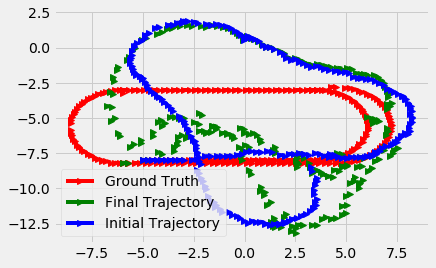

Iterations :  2  Loss :  74713.9


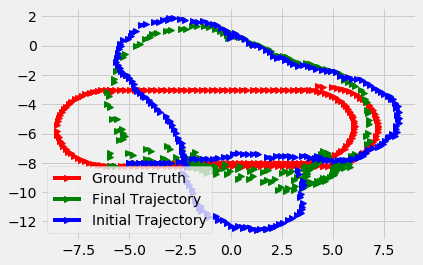

Iterations :  3  Loss :  205.92361


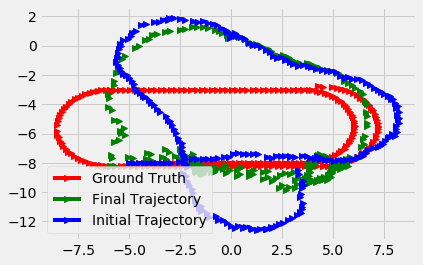

Iterations :  4  Loss :  37.413696


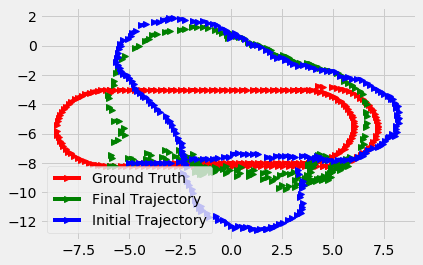

Iterations :  5  Loss :  36.489887


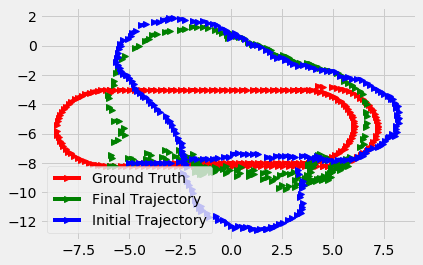

Iterations :  6  Loss :  36.433064


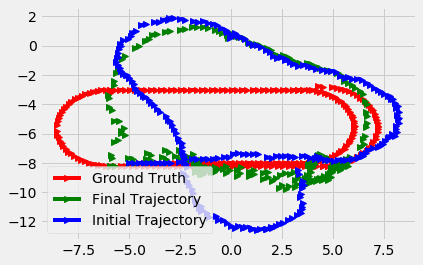

Iterations :  7  Loss :  36.427437


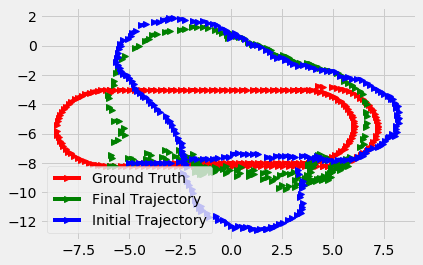

Iterations :  8  Loss :  36.42687


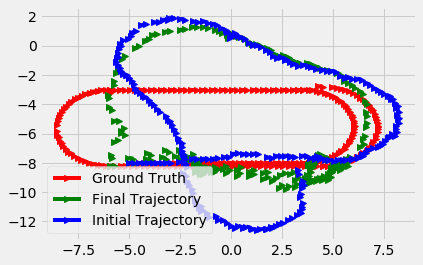

Iterations :  9  Loss :  36.4268


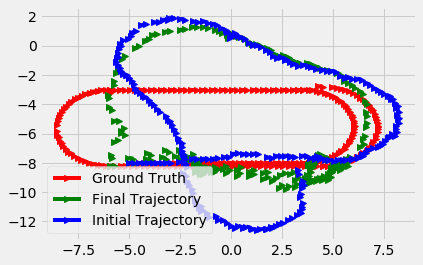

Iterations :  10  Loss :  36.4268


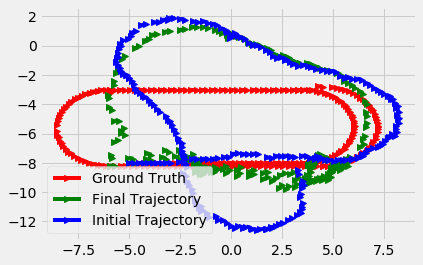

In [12]:
plt.style.use('fivethirtyeight')
def frobNorm(P1, P2, str1="mat1", str2="mat2"):
    jnp.set_printoptions(suppress=True)
    val = jnp.linalg.norm(P1 - P2, 'fro')
    print(f"Frobenius norm between {str1} and {str2} is: {val}")        
    
        
def levenMarq(x,y,theta,edges):
    cost_itr, x_itr =[], []
    it = 0
    lamda=0.1
    w=CreateOmega(2,500,1000)
    max_itr = 50
    tolerance = 0.000001
    while it < max_itr:
        vertices=jnp.concatenate((x,y,theta)).reshape(-1)
        f=get_fX(vertices,edges)
        lambf = lambda aa : get_fX(aa,edges)
        j=jacfwd(lambf)(vertices)
#         print(j.shape)
#         if it == 0 :
#             jj=analitical_jac(theta,edges)
        H, b = j.T@w@j + lamda*jnp.eye(360), j.T@w.T@f
        delx = -jnp.linalg.inv(H)@b
#         delx = jnp.reshape(delx,(3,delx.shape[0]//3))
        dX,dY,dT = jnp.reshape(delx,(3,len(delx)//3))
        x+=dX
        y+=dY
        theta+=dT
        costn = 0.5*f.T@w@f
        cost_itr.append(costn)
        l = len(cost_itr)
        print("err",it+1,"=",cost_itr[l-1])
        x_itr.append([x,y,theta])
        if it!=0:
            l = len(cost_itr)
            if cost_itr[l-1]>cost_itr[l-2]:
                lamda/=10
            else:
                lamda*=10
                
            if cost_itr[l-2] - cost_itr[l-1] < tolerance:
                break
        it+=1
        
    return cost_itr,x_itr

X = jnp.array(X)
Y = jnp.array(Y)
THETA = jnp.array(THETA)
cost,x=levenMarq(X, Y, THETA,edges) 
l = len(x)
makeg2o(x[l-1][0],x[l-1][1], x[l-1][2],g2ofile="opt.g2o")
makeg2o(x[l-1][0],x[l-1][1], x[l-1][2],g2ofile="opt-backup.g2o")




def final_output(vertex_gt, xn, yn, tn):  
    ax = plt.subplot()
    c = 0.25
    xgt, ygt=vertex_gt[0], vertex_gt[1]
    tg = vertex_gt[2]


    i = 0 
    while i < len(tg):
        pls, ply = c*math.cos(tg[i]) + xgt[i],  c*math.sin(tg[i]) + ygt[i]
        if i == 0:
            plt.plot([xgt[i], pls], [ygt[i], ply], 'r->', label="Ground Truth")
        else :
             plt.plot([xgt[i], pls], [ygt[i], ply], 'r->')
        i+=1

    
    i = 0
    while i < len(tn):
        pls, ply = c*math.cos(tn[i]) + xn[i],  c*math.sin(tn[i]) + yn[i]
        if i == 0 :
            plt.plot([xn[i], pls], [yn[i], ply], 'g->', label="Final Trajectory")
        else :
             plt.plot([xn[i], pls], [yn[i], ply], 'g->')
        i+=1
        

    i = 0
    while i < len(THETA):
        pls, ply = c*math.cos(THETA[i]) + X[i],  c*math.sin(THETA[i]) + Y[i]
        if i == 0 :
            plt.plot([X[i], pls], [Y[i], ply], 'b->', label="Initial Trajectory")
        else :
            plt.plot([X[i], pls], [Y[i], ply], 'b->')
        i+=1
    
    plt.legend()
    plt.show()
    

vertexgt = readVertex('./dataset/gt.txt')
for i in range(1, l+1):
    print("Iterations : ",str(i)," Loss : ",cost[i-1])
    xn,yn,tn=x[i-1][0],x[i-1][1],x[i-1][2]
    final_output(vertexgt, xn,yn,tn)




## 2.1 Answer

Give a detailed answer addressing the above questions. When I run the above code, it should follow points described above (such as plots at every 10 steps) and (When I run the above code, it should) write the optimized poses to a file named `opt.g2o`. As a backup, save another file `opt_backup.g2o` in an offline manner beforehand.

That apart, save important plots and add them here so that it can supplement your answer, for example you could add plots at crucial stages of optimization. You have to add useful metrics/plots from `EVO` (refer to supplementary notebook). Using EVO, the bare minimum you have to report is `mean absolute pose error (ape)` and `mean relative pose error (rpe)`. However, you are encouraged to use tools like `evo_traj` and [more](https://github.com/MichaelGrupp/evo/#command-line-interface) and add more plots/metrics. Marks will be awarded based on overall analysis & presentation which would reflect your understanding.

Note that `EVO` and `g2o_viewer` (below) could help you in debugging.

Add answer for 2.1 here:
During the experimentation with the information matrix values, we realised that the most important factor or constraint is the initial position, about which we are very sure of. So we fixed the values corresponding to it in the information matrix as highest. 
The next most important factor was the loop contraint information because using it we can optimise the shape of trajectory of the robot close to the actual shape of the trajectory. 
Odometry constrainsts are the least important because they are the values with which we initialise the positions. Also without external keypoints, it is almost impoossible to map the exact trajectory. 


#### Shape of Matrices
* Residual Matrix Shape :  (420, 1)
* Jacobian Matrix Shape :  (420, 360)
* Information Matrix Shape : (420, 420)


#### Odometric Edges Information : 200, Loop Edges Information : 10, Initial Edges Information : 1
Final Error : 1693.377
![Experiment1.png](./misc/q2/200-10-1.png)


#### Odometric Edges Information : 10, Loop Edges Information : 200, Initial Edges Information : 1
Final Error : 200.377
![Experiment1.png](./misc/q2/10-200-1.png)


#### Odometric Edges Information : 10, Loop Edges Information : 1, Initial Edges Information : 200
Final Error : 180.16
![Experiment1.png](./misc/q2/10-1-200.png)


#### Odometric Edges Information : 200, Loop Edges Information : 1, Initial Edges Information : 10
Final Error : 369.3849
![Experiment1.png](./misc/q2/200-1-10.png)


#### Odometric Edges Information : 2, Loop Edges Information : 500, Initial Edges Information : 1000
Final Error : 36.4268
![Experiment1.png](./misc/q2/2-500-1000.png)



## Evo Plots
![Experiment1.png](./misc/q2/evo2.png)
![Experiment1.png](./misc/q2/evo-2.png)
![Experiment1.png](./misc/q2/evo3.png)

## 2.2 Using g2o's optimization: g2o binary or g2o viewer 

Installation setup is described in supplementary notebook. More details for 2.2.1 and 2.2.2 can be found in the supplementary notebook.

### 2.2.1 Optimizing `edges.txt`
First task is to optimize the poses of dataset you've been working with so far.

### 2.2.2 Optimizing `intel` and `sphere` datasets
You have been given two datasets in the `data` folder. You have to use `g2o_viewer` to optimize these both. You have to experiment with the options/parameters available in the GUI. More instructions in supplementary notebook. You have to experiment till you get the trajectories which look like the following:

<table><tr>
<td> <img src="./misc/intel.jpg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="./misc/sphere.jpg" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

## 2.2 Answer

Add images: take screenshot of the GUI of `g2o_viewer` after optimization for all 3 [[CP-M]] and add here. Briefly describe what you had to do (detailed answer is not expected). g2o could potentially give you close to ground truth trajectory for all 3, but if you are unable to get to close to ground truth, add the best you can get.

Output of g2o viewer

Optimised trajectory for Q2.1(edges.txt)
<table><tr>
<td> <img src="./misc/Q2.2/Q2.1_optimise.png" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

Optimised trajectory for intel dataset
<table><tr>
<td> <img src="./misc/Q2.2/intel.png" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

Optimised trajectory for sphere dataset
<table><tr>
<td> <img src="./misc/Q2.2/sphere1.png" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="./misc/Q2.2/sphere2.png" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

We can use different optimiser, kernel width and different cost functions in robust kernel. One can even set number of iterations. After experimenting Huber cost function, 1 unit kernel width and lm_var_cholmod optimiser has been chosen to optimise all three trajectories with varying number of iterations.

###  * Important Information regarding Questions 3  & 4
Note that it is mandatory to attempt EITHER 3 OR 4, only one of it. If you attempt both, the question which you score more will be considered and the other as bonus question. 

It is encouraged for those into robotics/deep learning research to prefer 4 over 3.

# [Bonus*] 3. Deriving Motion model geometrically
\* -> read information above under section "Important Information regarding Questions 3  & 4"

 
The current robot state is as follows: ($i$ and $k$ are interchangably used below, sorry I am too lazy to edit now 😛)  
![robot-situation.png](./misc/robot-situation.png)

Can you derive the below equation using geometry? (Read on)

$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

In other words, we want to find $\delta$'s in terms of $\Delta$'s
$$\delta x = \Delta x \cos(\theta) - \Delta y \sin(\theta) \\
\delta y = \Delta y \cos(\theta) + \Delta x \sin(\theta) \tag{2}$$

where $\delta$'s are the updates in our motion model equation:
$$ x_{k+1} = x_{k} + \delta x \\
y_{k + 1} = y_k + \delta y \\
\theta_{k+1} = \theta_{k} + \delta \theta \tag{1}$$

Oh yes, $\theta$ is straightforward, i.e. $\delta \theta = \Delta \theta$ but why? 

Using geometry, you could just draw and insert a self-explanatory image as the answer to this question.

If you can derive it without using geometry purely using transform matrices/algebra, that is fine too. Whatever you're comfortable.

## 3. Answer


Your answer here.

<table><tr>
<td> <img src="./misc/Q3/Q3_1.jpeg" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="./misc/Q3/Q3_2.jpeg" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

# [Bonus*] 4. Research Paper Reading
\* -> read information above under section "Important Information regarding Questions 3  & 4"

(Do not get intimidated, you are not expected to do a thorough research analysis for this task. A high level understanding is sufficient.)


["Past, Present & Future of SLAM: Towards the Robust Perception Age"](https://arxiv.org/abs/1606.05830) is an exciting survey paper of 2016 which sums up, well, the "past, present & future" of SLAM. Your task is as follows:

1. Go through the sections "IV. LONG-TERM AUTONOMY II: SCALABILITY" & "III. LONG-TERM AUTONOMY I: ROBUSTNESS". Don't worry, you are not expected to have a deep understanding. Skip the parts which you don't understand at all. Go through it at a high level, and take a slightly closer look at "Open Problems" in these sections.

2. Read up common applications of deep learning for computer vision/robotics through blogs online (for example, first 4 points of [this](https://machinelearningmastery.com/applications-of-deep-learning-for-computer-vision/). Again, you are only expected to understand it at a high level, for example, 'semantic segmentation is an application of deep learning for computer vision which is the task of assigning a category to each of the pixels in the image'.

Firstly, summarize your understanding of the above two points.
   
Now, from the understanding you've gathered so far, how would you approach solving those "Open Problems"? 
Can these algorithms help in dealing with some of the issues you might have faced during this project? Can the deep learing based high level understanding of the world help in SLAM? In the context of long term autonomy, imagine tomorrow's world with a buddy robot R2-D2 which follows you wherever you go... Now imagine how easily the trajectory can diverge, how big the map could soon become and how the computation could easily become intractable.   

Answer the above questions in the context of this project and those 2 sections of the survey paper.

## 4. Answer
There are still a lot of challenges making slam robust and scalable. To make slam a out of box kind of thing, we still need a lot of work. For example automatic parameter tuning is so critical for the slam to generalise in all kind of environments. Tuning parameters is a hard process and to tune is for every new environment that we put the robot in, is costly. Similar issues related to robustness are hardware failuire, outlier detection. 
For slam to be applied in real world, it should be scalable. Scalability has some big research problems because the quality should be good even in large environments like oceans and whole cities and over extended period of time. For example if we visit an area multiple times, how to control the sparsity of the graph. 

In the second post, various application of computer vision tasks like object detection, semantic segmentation are discussed. With the advent of deep learning, we are able to perform much better in these tasks. 

Failsafe SLAM and recovery : Outlier detection can be approached in many ways. Maybe a network can be trained, with a suitable loss function to detect outlier. Since inclusion of an outlier will cause more problems than not including an inlier, maybe we can bias the loss in that way. 


Automatic parameter tuning: This will need an online optimisation technique. One thing that I think will work is how we learn features. If we learn features in an online fashion, then the dependency on tuning the parameters could reduce. 


Learning, forgetting, remembering: This is much like the task of sequence to sequence translation in NLP. When to remember, when to forget, which information is useful. Maybe using an lstm network as in nlp for information remembering. But they are very slow, so I am not sure if we could use them in an online optimisation problem. 
 
 
Yes, a semantic understanding of the world could be very useful in solving the problems faced in slam. Although there is a big problem in deep learning is generalissation outside the dataset. Robots have to working in varying environments, where the external factors can be drastically different. We also discussed the possiblilty of online deep feature learning, so as to improve generalisation across environments. 

We understand that on the large scale, the problem of localisation and mapping can easily become intractable. We thinkk that storing the map of the whole world is too expensive. Instead we could store some local features, which could be used for localisation anda pseudo map. For this partcular R2DX buddy example, we can give information regarding the owner a very high value so that it never leaves the owner. This will also reduce the amount of memory and localisation will be good.

Your answer here.

### Fun section
Check the end of your Project-1 homepage on Notion. :)